# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Using cached torch-1.7.1-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
  Using cached torchvision-0.8.2-cp38-cp38-manylinux1_x86_64.whl (12.8 MB)
ERROR: torchaudio 0.7.0 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0+cu110
    Uninstalling torch-1.7.0+cu110:
      Successfully uninstalled torch-1.7.0+cu110
  Rolling back uninstall of torch
  Moving to /home/adrien/.local/bin/convert-caffe2-to-onnx
   from /tmp/pip-uninstall-m1lbdn_7/convert-caffe2-to-onnx
  Moving to /home/adrien/.local/bin/convert-onnx-to-caffe2
   from /tmp/pip-uninstall-m1lbdn_7/convert-onnx-to-caffe2
  Moving to /home/adrien/.local/lib/python3.8/site-packages/caffe2/
   from /home/adrien/.local/lib/python3.8/site-packages/~affe2
  Moving to /home/adrien/.local/lib/python3.8/site-packages/torch-1.7.0+cu110.dist-info/
   from /home/adrien/.local/lib/python3.8/site-packages/~orch-1.7.0+cu110.dist-info
  Moving t

'1.7.0+cu110'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///home/adrien/Desktop/AI-SandBox/detectron2_repo
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.3
    Uninstalling detectron2-0.3:
      Successfully uninstalled detectron2-0.3
  Running setup.py develop for detectron2


## start here if local

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

import datetime, os
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
 #clean outputs for tensorboard
!rm output/*
#%load_ext tensorboard
#!tensorboard --logdir ./output & > /dev/null
#%reload_ext tensorboard

# Train on a custom COCO dataset
In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.


Download the dataset if you are running on google colab

In [5]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    !unzip -o /content/drive/MyDrive/AI/dataset.zip > /dev/null
else:
    print("not running in google colaboratory")

not running in google colaboratory


Register the dataset

In [6]:
from detectron2.data.datasets import register_coco_instances
# main one : 
register_coco_instances("cars_train", {}, "coco_output/train.json", "dataset/train")
register_coco_instances("cars_val", {}, "coco_output/val.json", "dataset/val")

# tests :
#register_coco_instances("cars", {}, "../save.json", "../bdd100k_images/bdd100k/images/100k/train/")
#register_coco_instances("cars_val", {}, "../comma200/comma200_coco.json", "../comma200/")
#register_coco_instances("cars", {}, "../convert_bdd100k_to_coco_format/save.json", "../bdd100k_images/bdd100k/images/100k/train/")

In [7]:
car_train_metadata = MetadataCatalog.get("cars_train")
dataset_dicts = DatasetCatalog.get("cars_train")

WARNING [12/12 22:52:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/12 22:52:24 d2.data.datasets.coco]: Loaded 75 images in COCO format from coco_output/train.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



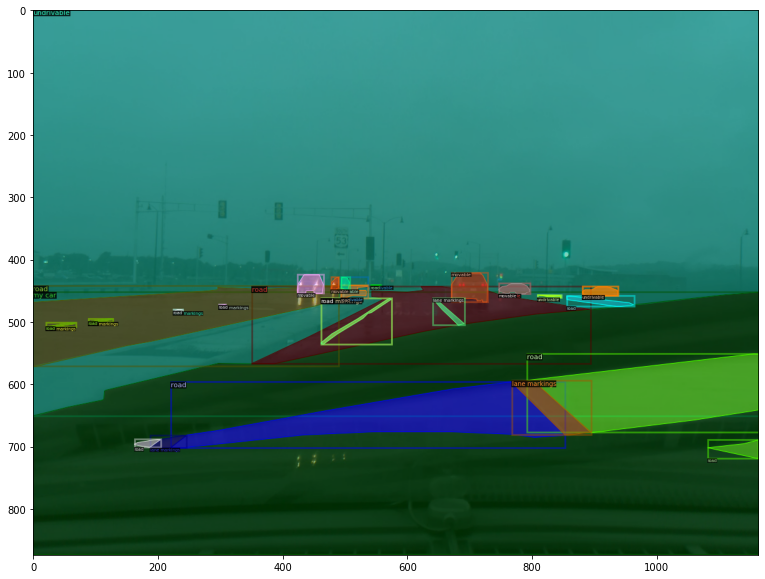

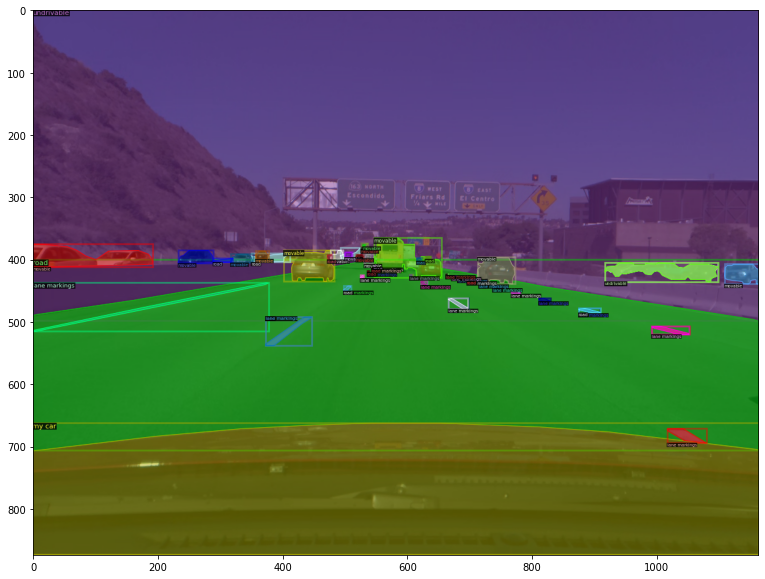

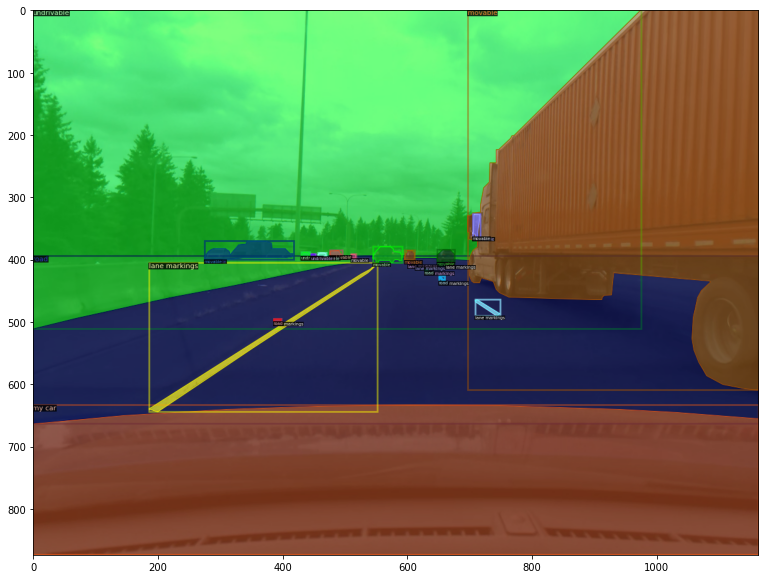

In [8]:
import random

for d in random.sample(dataset_dicts, 3):
      img = cv2.imread(d["file_name"])
      visualizer = Visualizer(img[:, :, ::-1], metadata=car_train_metadata, scale=1)
      vis = visualizer.draw_dataset_dict(d)
      plt.figure(figsize = (13,13))
      plt.imshow(vis.get_image())

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the car_train_metadata dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("cars_train",)
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.DATASETS.TEST = ("") #"cars_val"   # no metrics implemented for this dataset
#cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02 #default : 0.02
cfg.SOLVER.MAX_ITER = 250    #default : 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # default 128 faster, and good enough for this toy dataset
#cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/12 22:52:30 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/home/adrien/Desktop/AI-SandBox/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/adrien/Desktop/AI-SandBox/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/adrien/Desktop/AI-SandBox/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internal

[12/12 22:52:35 d2.utils.events]:  eta: 0:00:58  iter: 19  total_loss: 3.586  loss_cls: 1.294  loss_box_reg: 0.38  loss_mask: 0.4886  loss_rpn_cls: 0.3467  loss_rpn_loc: 0.8835  time: 0.2575  data_time: 0.0110  lr: 0.00039962  max_mem: 2782M
[12/12 22:52:41 d2.utils.events]:  eta: 0:00:54  iter: 39  total_loss: 2.403  loss_cls: 0.6086  loss_box_reg: 0.3811  loss_mask: 0.3606  loss_rpn_cls: 0.1564  loss_rpn_loc: 0.8815  time: 0.2608  data_time: 0.0038  lr: 0.00079922  max_mem: 2782M
[12/12 22:52:46 d2.utils.events]:  eta: 0:00:50  iter: 59  total_loss: 2.358  loss_cls: 0.4857  loss_box_reg: 0.4542  loss_mask: 0.3134  loss_rpn_cls: 0.1141  loss_rpn_loc: 0.8232  time: 0.2650  data_time: 0.0035  lr: 0.0011988  max_mem: 2782M
[12/12 22:52:51 d2.utils.events]:  eta: 0:00:44  iter: 79  total_loss: 2.016  loss_cls: 0.4066  loss_box_reg: 0.4144  loss_mask: 0.2718  loss_rpn_cls: 0.08476  loss_rpn_loc: 0.9156  time: 0.2649  data_time: 0.0036  lr: 0.0015984  max_mem: 2782M
[12/12 22:52:57 d2.utils

Now, we perform inference with the trained model on the car_train_metadata dataset. First, let's create a predictor using the model we just trained:



In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("cars_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

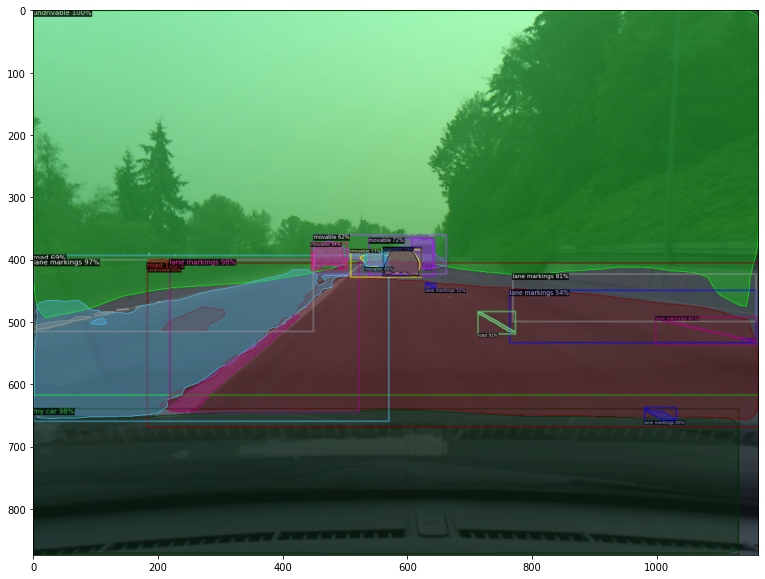

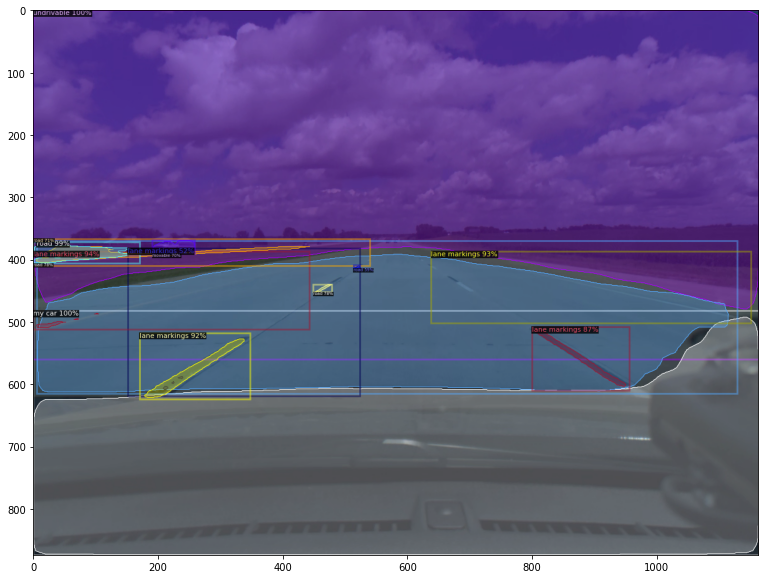

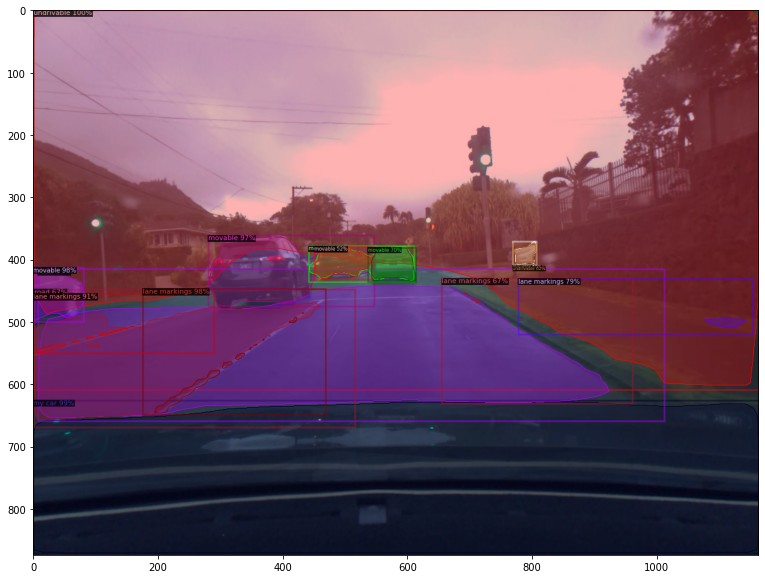

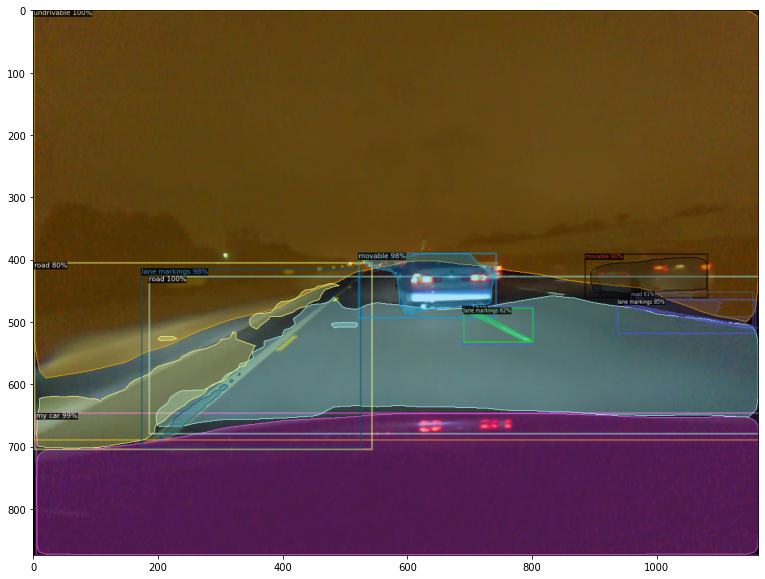

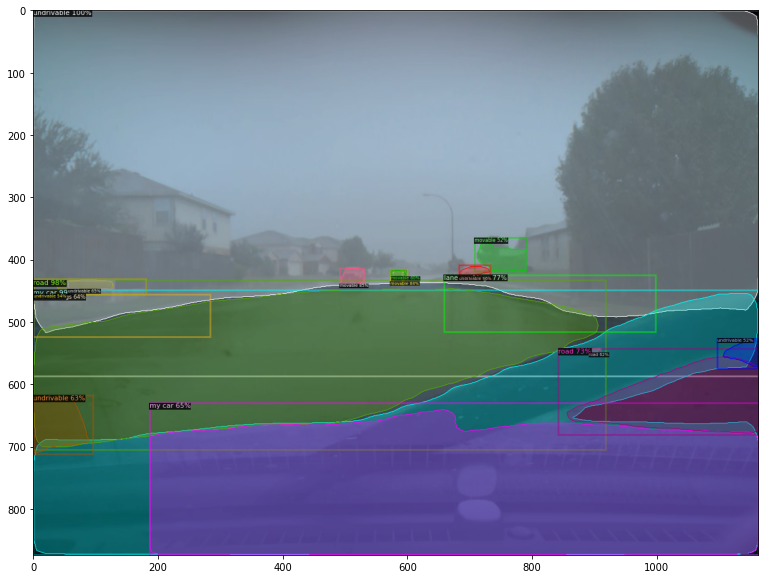

In [11]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=car_train_metadata, 
                       scale=1, 
                       instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize = (13,13))
        plt.imshow(v.get_image())

In [12]:
car_train_metadata

namespace(name='cars_train',
          json_file='coco_output/train.json',
          image_root='dataset/train',
          evaluator_type='coco',
          thing_classes=['road',
                         'lane markings',
                         'undrivable',
                         'movable',
                         'my car'],
          thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4})

## Benchmark inference speed

In [13]:
cfg.MODEL.DEVICE = "cpu"

import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.07,fps:13.59


In [14]:
outputs = predictor(im)
print(outputs)

{'instances': Instances(num_instances=17, image_height=874, image_width=1164, fields=[pred_boxes: Boxes(tensor([[0.0000e+00, 0.0000e+00, 1.1640e+03, 5.8714e+02],
        [0.0000e+00, 4.4868e+02, 1.1640e+03, 8.7400e+02],
        [3.2334e-01, 4.3346e+02, 9.1779e+02, 7.0459e+02],
        [6.8313e+02, 4.0948e+02, 7.3297e+02, 4.2757e+02],
        [4.9171e+02, 4.1368e+02, 5.3104e+02, 4.3933e+02],
        [5.7318e+02, 4.1564e+02, 6.0037e+02, 4.3566e+02],
        [6.5909e+02, 4.2452e+02, 9.9842e+02, 5.1575e+02],
        [8.4243e+02, 5.4309e+02, 1.1640e+03, 6.8096e+02],
        [1.8661e+02, 6.3021e+02, 1.1629e+03, 8.7400e+02],
        [5.5542e+01, 4.3354e+02, 1.2986e+02, 4.4819e+02],
        [0.0000e+00, 4.5593e+02, 2.8437e+02, 5.2415e+02],
        [0.0000e+00, 6.1812e+02, 9.5942e+01, 7.1166e+02],
        [8.9141e+02, 5.4258e+02, 9.0976e+02, 5.5004e+02],
        [5.7449e+02, 4.1703e+02, 5.9773e+02, 4.2734e+02],
        [6.1551e-01, 4.3141e+02, 1.8099e+02, 4.5638e+02],
        [1.0972e+03, 5.271